Осы аптадағы тәжірибелік зертханада сіз бір конфигурацияны қолданып көресіз және бұл желілердің көптеген түрлерінің тіркесімі: деректер терезелері конвульсиядан өтеді, одан кейін жинақталған LSTM, содан кейін жинақталған тығыз қабаттар.

## Қажетті модульдерді импорттаңыз

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

In [28]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Уақыттық қатар деректерін визуалдау

    Параметрлер:
      x (бүтін сандар массиві) - x осіне арналған мәндерді қамтиды
      y (бүтін сандар массиві немесе массивтердің жұбы) - y осіне арналған мәндерді қамтиды
      format (жол) - график сызығының стилі
      start (бүтін сан) - графикте көрсетілетін бірінші уақыт қадамы
      end (бүтін сан) - графикте көрсетілетін соңғы уақыт қадамы
      title (жол) - графиктің тақырыбы
      xlabel (жол) - x осінің атауы
      ylabel (жол) - y осінің атауы
      legend (жолдар тізімі) - графиктің легендасы
    """

    # График фигурасының өлшемдерін орнату
    plt.figure(figsize=(10, 6))

    # Екіден көп қатарды графиктеу қажет пе екенін тексеру
    if type(y) is tuple:

      # y элементтері бойынша цикл жасау
      for y_curr in y:

        # x және ағымдағы y мәндерін графиктеу
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # x және y мәндерін графиктеу
      plt.plot(x[start:end], y[start:end], format)

    # x осінің атауын белгілеу
    plt.xlabel(xlabel)

    # y осінің атауын белгілеу
    plt.ylabel(ylabel)

    # Легенданы орнату
    if legend:
      plt.legend(legend)

    # Тақырыпты орнату
    plt.title(title)

    # Графиктің үстіне тор сызбасын қосу
    plt.grid(True)

    # Экранда графикті көрсету
    plt.show()

## Деректер жинағын жүктеп алыңыз және алдын ала қараңыз

In [7]:
!curl -O https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 70827  100 70827    0     0  81276      0 --:--:-- --:--:-- --:--:-- 81410


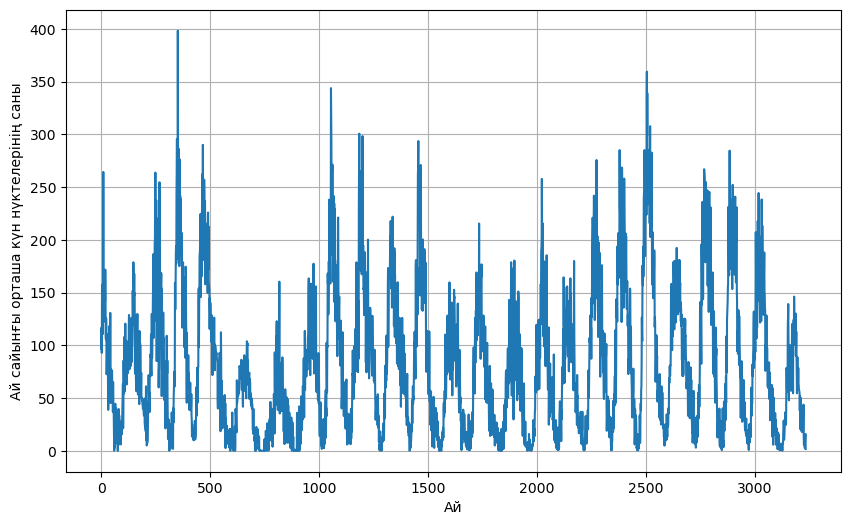

In [16]:
# Тізімдерді инициализациялау
time_step = []
sunspots = []

# CSV файлын ашу
with open('./Sunspots.csv') as csvfile:

  # Оқырманды инициализациялау
  reader = csv.reader(csvfile, delimiter=',')

  # Бірінші жолды өткізіп жіберу
  next(reader)

  # Әр жолдан уақыт қадамы мен күн нүктелерінің санын тізімге қосу
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

# Тізімдерді numpy массивтеріне ауыстыру
time = np.array(time_step)
series = np.array(sunspots)

# Деректерді алдын ала қарау
plot_series(time, series, xlabel='Ай', ylabel='Ай сайынғы орташа күн нүктелерінің саны')

## Деректер жиынын бөліңіз

In [17]:
# Define the split time
split_time = 3000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Мүмкіндіктер мен белгілерді дайындаңыз

In [18]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Деректер жиынтығының терезелерін құрады

    Параметрлер:
      series (float сандар массиві) - уақыттық қатардың мәндерін қамтиды
      window_size (бүтін сан) - ерекшелікке енгізілетін уақыт қадамдарының саны
      batch_size (бүтін сан) - пакет көлемі
      shuffle_buffer (бүтін сан) - араластыру әдісі үшін қолданылатын буфер көлемі

    Қайтарады:
      dataset (TF Dataset) - уақыттық терезелерді қамтитын TF деректер жиынтығы
    """

    # RNN қабаттарының ерекшелік өлшемі үшін қосымша ось қосу
    series = tf.expand_dims(series, axis=-1)

    # Серия мәндерінен TF деректер жиынтығын жасау
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Деректерді терезеге бөлу, тек көрсетілген өлшемдегі терезелерді таңдау
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Терезелерді бір пакетке біріктіру арқылы тегістеу
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Ерекшеліктер мен белгілерді қамтитын кортеждерді жасау
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Терезелерді араластыру
    dataset = dataset.shuffle(shuffle_buffer)

    # Терезелердің пакеттерін жасау
    dataset = dataset.batch(batch_size)

    # Оқыту үшін деректер жиынтығын оңтайландыру
    dataset = dataset.cache().prefetch(1)

    return dataset

егер сіздің нәтижелеріңіз жақсы болмаса, мұнда параметрлерді өзгертуге және модельдің жақсырақ үйренетінін көруге болады.

In [60]:
# Параметрлер
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Деректер жиынының терезелерін жасаңыз
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Үлгіні құрастыру

In [61]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,1)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal'),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

# Үлгінің қысқаша мазмұнын басып шығарыңыз
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

## Оқу жылдамдығын реттеңіз

оңтайлы оқу жылдамдығын таңдағыңыз келеді.

In [62]:
# Бастапқы салмақтарды алыңыз
init_weights = model.get_weights()

In [63]:
# Оқу жылдамдығын реттегішті орнату
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Оптимизаторды инициализациялау
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Оқыту параметрлерін орнату
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Модельді оқыту
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 17s 53ms/step - loss: 103.5248 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 5s 49ms/step - loss: 53.1141 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 4s 46ms/step - loss: 41.3117 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 5s 51ms/step - loss: 38.5589 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 5s 51ms/step - loss: 37.0347 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 4s 48ms/step - loss: 35.6019 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 4s 48ms/step - loss: 34.5454 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 5s 49ms/step - loss: 33.6784 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 5s 49ms/step - loss: 32.8318 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 4s 47ms/step - loss: 32.2164 - lr: 2.8184e-08
Epoch 1

(1e-08, 0.001, 0.0, 100.0)

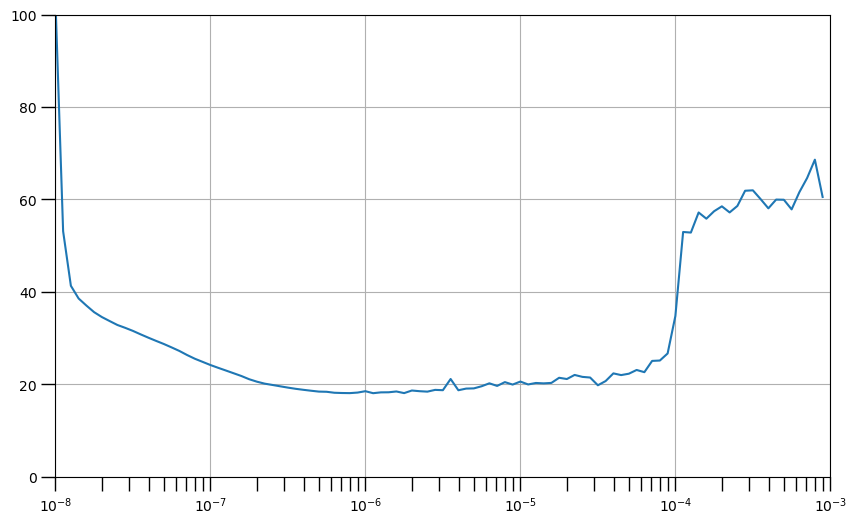

In [64]:
# Оқу жылдамдығының массивін анықтау
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Фигураның өлшемін орнату
plt.figure(figsize=(10, 6))

# Торды орнату
plt.grid(True)

# Логарифмдік масштабта жоғалту мәнін графиктеу
plt.semilogx(lrs, history.history["loss"])

# Тик белгішелерінің өлшемін ұлғайту
plt.tick_params('both', length=10, width=1, which='both')

# Графиктің шекараларын орнату
plt.axis([1e-8, 1e-3, 0, 100])

## Үлгіні жаттықтыру

Енді үлгіні қалпына келтіруге және үйретуге болады. Ол төмендегі ұяшықта 100 дәуірге орнатылған, бірақ қаласаңыз, оны көбейтуге болады.

In [67]:
# Keras жасаған күйді қалпына келтіру
tf.keras.backend.clear_session()

# Салмақтарды қалпына келтіру
model.set_weights(init_weights)

In [68]:
# Оқу жылдамдығын орнату
learning_rate = 8e-7

# Оптимизаторды орнату
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Оқыту параметрлерін орнату
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [69]:
# Модельді оқыту
history = model.fit(train_set, epochs=100)

Epoch 1/100
93/93 [==============================] - 15s 52ms/step - loss: 39.4919 - mae: 39.9875
Epoch 2/100
93/93 [==============================] - 4s 47ms/step - loss: 23.0449 - mae: 23.5399
Epoch 3/100
93/93 [==============================] - 5s 50ms/step - loss: 20.9704 - mae: 21.4636
Epoch 4/100
93/93 [==============================] - 5s 50ms/step - loss: 20.1787 - mae: 20.6720
Epoch 5/100
93/93 [==============================] - 4s 46ms/step - loss: 19.3107 - mae: 19.8046
Epoch 6/100
93/93 [==============================] - 4s 48ms/step - loss: 18.8859 - mae: 19.3791
Epoch 7/100
93/93 [==============================] - 5s 49ms/step - loss: 18.4406 - mae: 18.9333
Epoch 8/100
93/93 [==============================] - 5s 49ms/step - loss: 18.6336 - mae: 19.1263
Epoch 9/100
93/93 [==============================] - 4s 45ms/step - loss: 18.1895 - mae: 18.6827
Epoch 10/100
93/93 [==============================] - 5s 49ms/step - loss: 18.2907 - mae: 18.7836
Epoch 11/100
93/93 [========

Сіз жаттығуды визуализациялай аласыз және жоғалту мен MAE әлі де төмендейтінін көре аласыз.

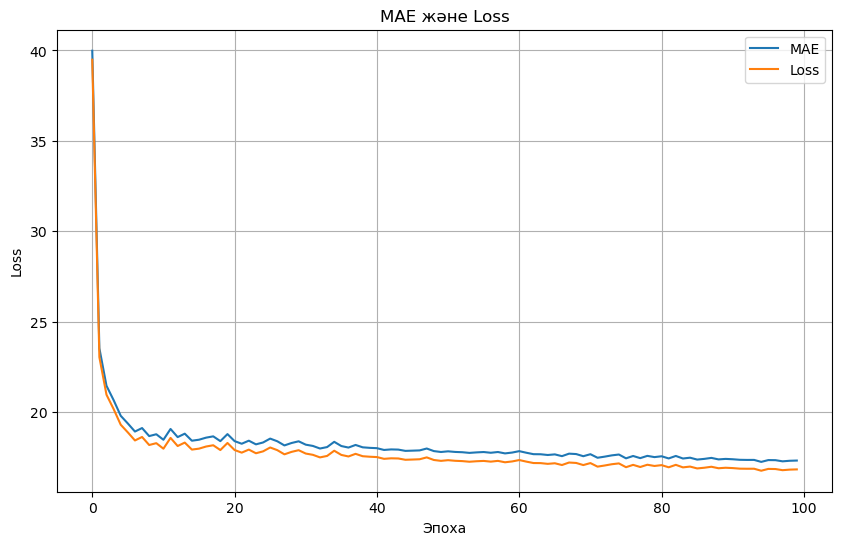

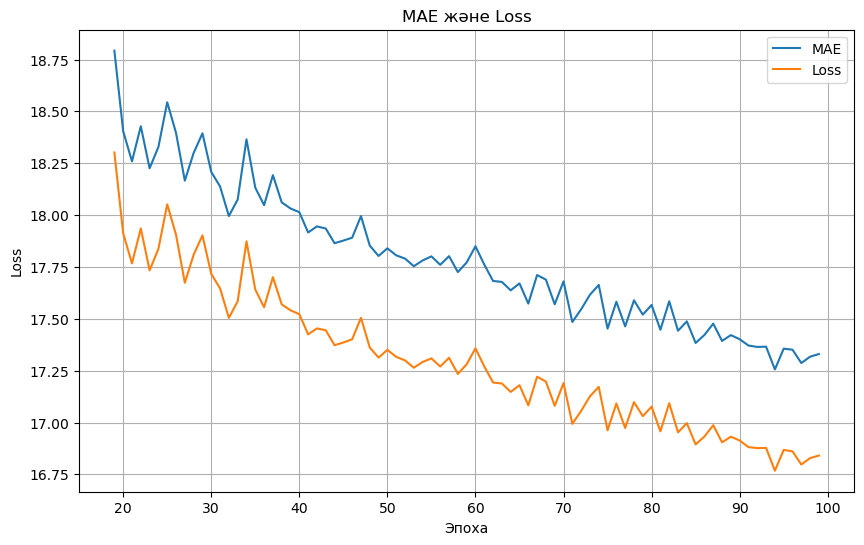

In [70]:
# Тарих жазбасынан mae және loss мәндерін алу
mae = history.history['mae']
loss = history.history['loss']

# Эпохалардың санын алу
epochs = range(len(loss))

# mae және loss графигін салу
plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE және Loss',
    xlabel='Эпоха',
    ylabel='Loss',
    legend=['MAE', 'Loss']
)

# Тек соңғы 80% эпохаларды графиктеу
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Үлкейтілген mae және loss графигін салу
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE және Loss',
    xlabel='Эпоха',
    ylabel='Loss',
    legend=['MAE', 'Loss']
)

## Модель болжауы

Алдыңғыдай, валидациялық жиынтықтың уақыт диапазоны бойынша болжамдарды алып, метрикаларды есептей аласыз.

In [71]:
def model_forecast(model, series, window_size, batch_size):
    """Модельді қолданып, деректер терезелеріндегі болжамдарды генерациялайды

    Параметрлер:
      model (TF Keras Model) - деректер терезелерін қабылдайтын модель
      series (float сандар массиві) - уақыттық қатардың мәндерін қамтиды
      window_size (бүтін сан) - терезеге енгізілетін уақыт қадамдарының саны
      batch_size (бүтін сан) - пакет көлемі

    Қайтарады:
      forecast (numpy массиві) - болжамдарды қамтитын массив
    """

    # RNN қабаттарының ерекшелік өлшемі үшін қосымша ось қосу
    series = tf.expand_dims(series, axis=-1)

    # Серия мәндерінен TF деректер жиынтығын жасау
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Деректерді терезеге бөлу, тек көрсетілген өлшемдегі терезелерді таңдау
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Терезелерді бір пакетке біріктіру арқылы тегістеу
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Терезелердің пакеттерін жасау және алдын ала жүктеу
    dataset = dataset.batch(batch_size).prefetch(1)

    # Барлық деректер жиынтығына болжам алу
    forecast = model.predict(dataset, verbose=0)

    return forecast


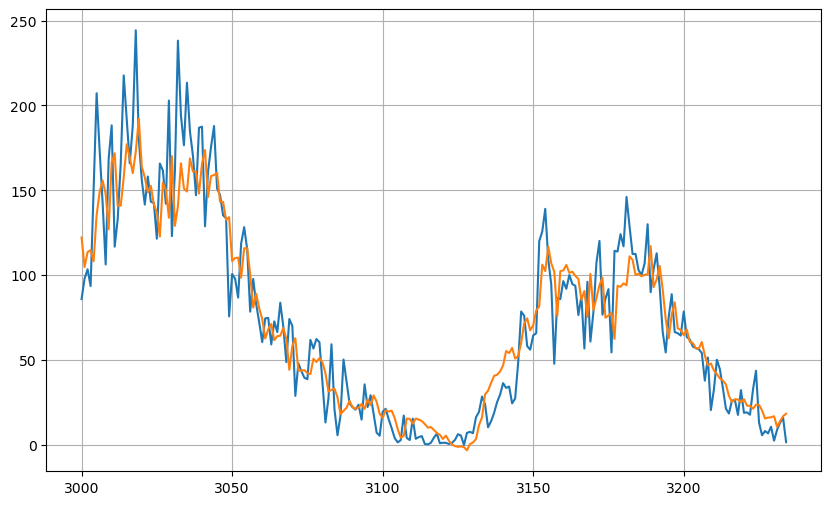

In [72]:
# Түпнұсқа қатарды қысқарту
forecast_series = series[split_time-window_size:-1]

# Болжамдарды генерациялау үшін көмекші функцияны қолдану
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Бірөлшемді осьті алып тастау
results = forecast.squeeze()

# Нәтижелерді графиктеу
plot_series(time_valid, (x_valid, results))

In [25]:
# Compute the MAE
print(tf.keras.metrics.mae(x_valid, results).numpy())

0.23403479


## Тапсырма

Уақыт қатарларының деректер жинағын желіден табыңыз немесе оны өзіңіз талдай аласыз, берілген үлгіні пайдаланып уақыт қатарының болжамын жасаңыз

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


In [ ]:
url = "https://datahub.io/core/global-temp/r/monthly.csv"

In [3]:

df = pd.read_csv("temperature_data.csv")
df.to_csv("temperature_data.csv")  # CSV файлы ретінде сақтау
df.head()


,Unnamed: 0.1,Unnamed: 0,Source,Year,Mean
0,0,0,gcag,1850-01,-0.6746
1,1,1,gcag,1850-02,-0.3334
2,2,2,gcag,1850-03,-0.5913
3,3,3,gcag,1850-04,-0.5887
4,4,4,gcag,1850-05,-0.5088


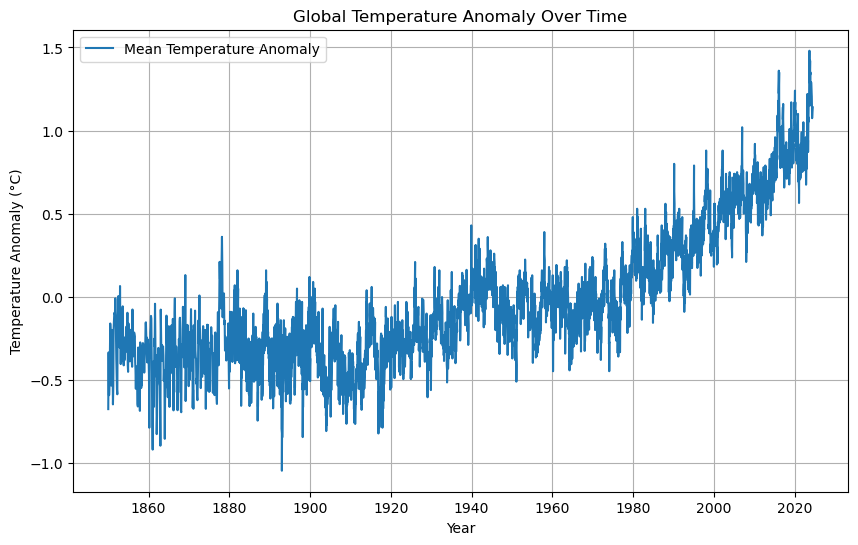

In [4]:

# Уақыт бағанын `datetime` форматына өзгерту
df["Year"] = pd.to_datetime(df["Year"])

# Қажетсіз бағанды жою
df = df.drop(columns=["Source"])

# Уақыттық қатарларды NumPy массивіне айналдыру
time = np.array(df["Year"])
series = np.array(df["Mean"])

# Деректерді визуализациялау
plt.figure(figsize=(10, 6))
plt.plot(time, series, label="Mean Temperature Anomaly")
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (°C)")
plt.title("Global Temperature Anomaly Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [5]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Year,Mean
0,0,0,1850-01-01,-0.6746
1,1,1,1850-02-01,-0.3334
2,2,2,1850-03-01,-0.5913
3,3,3,1850-04-01,-0.5887
4,4,4,1850-05-01,-0.5088


In [6]:
# 3. Деректерді бөлу
split_time = int(len(series) * 0.8)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Уақыттық қатар деректерін терезелеу үшін функция

    Параметрлер:
      series (numpy.ndarray) - уақыттық қатар деректері
      window_size (int) - терезе өлшемі
      batch_size (int) - пакет өлшемі
      shuffle_buffer (int) - араластыру буферінің өлшемі

    Қайтарады:
      dataset (tf.data.Dataset) - терезеленген уақыттық қатар деректер жиынтығы
    """
    # NumPy массивін TensorFlow тензорына айналдыру
    series = tf.convert_to_tensor(series, dtype=tf.float32)

    # Қосымша ось қосу (RNN қабаттары үшін)
    series = tf.expand_dims(series, axis=-1)

    # TF Dataset құру
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Деректерді терезелеу
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Терезелерді біріктіру
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Терезелерді ерекшеліктер (X) және белгілер (y) ретінде бөлу
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Араластыру және пакеттеу
    dataset = dataset.shuffle(shuffle_buffer).batch(batch_size).cache().prefetch(1)

    return dataset

# Терезеленген оқыту деректер жиынтығын жасау
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


In [8]:
# 5. Нейрондық желі құру
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding='causal', input_shape=(window_size, 1)),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 10)
])
# Модель құрылымын шығару
model.summary()


C:\Users\newst\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,575 (267.87 KB)

 Trainable params: 68,575 (267.87 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
init_weights = model.get_weights()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0849 - learning_rate: 1.0000e-08
Epoch 2/100
15/95 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1057

C:\Users\newst\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0846 - learning_rate: 1.1220e-08
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0842 - learning_rate: 1.2589e-08
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0837 - learning_rate: 1.4125e-08
Epoch 5/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0832 - learning_rate: 1.5849e-08
Epoch 6/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0827 - learning_rate: 1.7783e-08
Epoch 7/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0821 - learning_rate: 1.9953e-08
Epoch 8/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0814 - learning_rate: 2.2387e-08
Epoch 9/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0806 - learning_rate: 2.5119e-08
Epoch 10/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0798 - learning_rate: 2.8184e-08
Epoch 11/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0788 - learning_rate: 3.1623e-08
Epoch 12/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss:

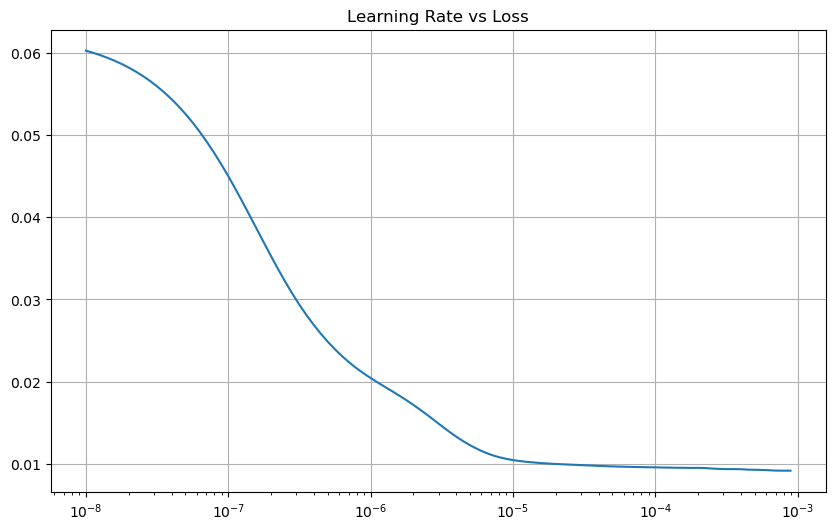

In [10]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.figure(figsize=(10, 6))
plt.semilogx(lrs, history.history["loss"])  
plt.grid(True)
plt.title("Learning Rate vs Loss")
plt.show()


In [11]:
tf.keras.backend.clear_session()
model.set_weights(init_weights)
learning_rate = 8e-7
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(train_set, epochs=100)


Epoch 1/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0799 - mae: 0.3410
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0590 - mae: 0.2868
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0461 - mae: 0.2497
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0384 - mae: 0.2255
Epoch 5/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0335 - mae: 0.2091
Epoch 6/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0301 - mae: 0.1972
Epoch 7/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0277 - mae: 0.1880
Epoch 8/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0258 - mae: 0.1810
Epoch 9/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0243 - mae: 0.1754
Epoch 10/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0232 - mae: 0.1709
Epoch 11/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0223 - mae: 0.1672
Epoch 12/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0216 - mae: 0.1641
Epoch 13/100
95/95 ━━━━━━

In [13]:
#  Болжау
forecast_series = series[split_time - window_size:-1]

def model_forecast(model, series, window_size, batch_size):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset, verbose=0)
    return forecast

forecast = model_forecast(model, forecast_series, window_size, batch_size)
results = forecast.squeeze()


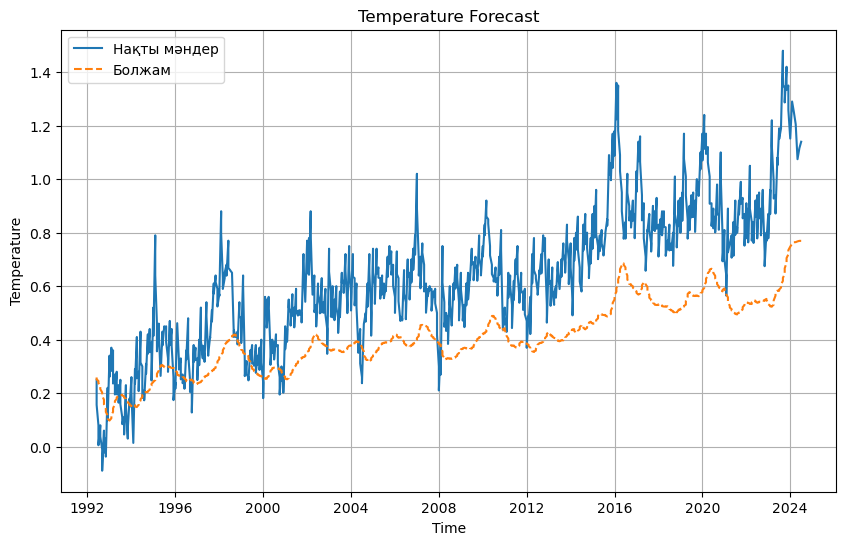

In [14]:
#  Графиктеу
plt.figure(figsize=(10, 6))
plt.plot(time_valid, x_valid, label="Нақты мәндер")
plt.plot(time_valid, results, label="Болжам", linestyle="dashed")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("Temperature Forecast")
plt.grid(True)
plt.show()


In [27]:
# Compute the MAE
print(tf.keras.metrics.mae(x_valid, results).numpy())

0.23403479
